Check splitting encoder behaviour in Voja according to the maximum learning rate

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes, list_as_ascii, gen_added_strings
from nengo_learn_assoc_mem.paths import data_path
from nengo_learn_assoc_mem.learning_rules.fake_voja import FakeVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple
import os

In [2]:
class MaxMixed(FakeVoja):

    def __init__(self, encoders: np.ndarray, bias: float, post_tau=0.005, learning_rate=1e-3, radius=1.):
        super().__init__(encoders, post_tau, learning_rate)
        self.radius = radius
        self.bias = bias

    def encode(self, t):
        # highly reacting neurons: 1000-500 = 500
        # low reacting neurons: 1-500 = -499, ie switches learning around
        # problem is tons of zeros, so let's assume it knows the max

        threshold = self.bias * np.max(self.acts)

        lr = self.enabled * self.learning_rate
        delta = lr * (self.acts[:, None] - threshold) * (self.encoders - self.in_sig)
        mod_enc = self.encoders + delta
        mag = np.linalg.norm(mod_enc, axis=1)
        self.encoders = self.radius / mag[:, None] * mod_enc

        if (t / self.dt % self.period) < 1:
            self.encoder_hist.append(self.encoders.copy())

        return np.dot(self.encoders, self.in_sig)

# Full Vocab

## Setup

In [328]:
n_items = 16
dimensions = 32
n_neurons = 1000
dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [329]:
n_repeats = 1
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)
rng = np.random.RandomState(seed+1)

intercepts = np.ones(n_neurons) * 0.2
#intercepts = nengo.dists.Uniform(0.01, 0.15).sample(n_neurons, rng=rng)

In [330]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [331]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [332]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Train

If you set the bias too low, it's basically just Voja. If you set the bias too high, there's a mismatch between FAN2 targets and foils. The Learning Rate is doing really weird stuff.

In [526]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
t_sim = n_repeats*len(feed_vecs)*t_each + t_pause
nvoja_lr = -1e-6 / n_repeats

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    nvoja_learn = nengo.Node(lambda t: 1-feed.paused)
    paused = nengo.Node(lambda t: feed.paused)

    neg_voja = MaxMixed(enc.copy(), 0.2, learning_rate=nvoja_lr)
    ens = nengo.Ensemble(n_neurons, dimensions, seed=seed)

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(nvoja_learn, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)
    p_paused = nengo.Probe(paused,)

with nengo.Simulator(model) as sim:
    sim.run(t_sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [527]:
fin_enc = neg_voja.encoder_hist[-1].copy()

## Verification

In [528]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [529]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

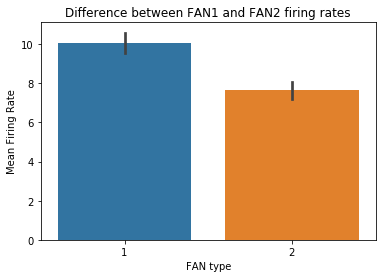

In [530]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

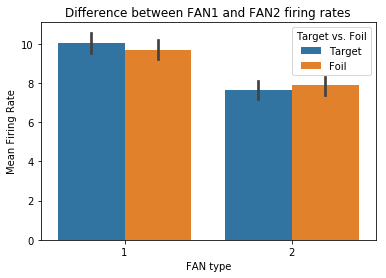

In [531]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

In [532]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [533]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: feed.paused)
    meg_nd = nengo.Node(lambda t, x: np.sum(x),
                        size_in=n_neurons, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    nengo.Connection(ens.neurons, meg_nd, synapse=None)

    p_meg = nengo.Probe(meg_nd, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [534]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [535]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

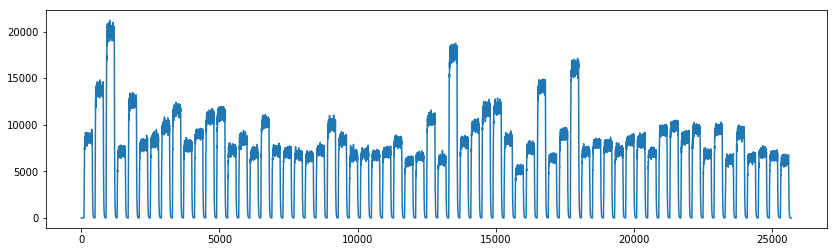

In [536]:
test_meg = test_sim.data[p_meg].squeeze()
plt.figure(figsize=(14, 4))
plt.plot(test_meg)

In [537]:
fan1_resp = test_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = test_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = test_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = test_meg[foil2_slc].reshape((-1, td_each))

c:\tools\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


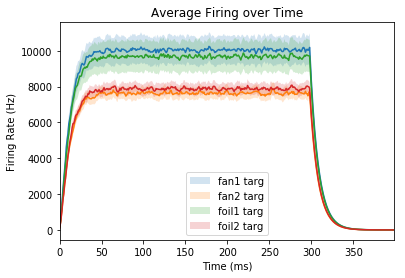

In [538]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

The slight mismatch between FOIL1 and FOIL2 can probably be resolved with noisy input vectors.

# Test association

## PES

In [622]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [623]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens.neurons, output, transform=np.zeros((dimensions, n_neurons)),
                                learning_rule_type=nengo.PES(5e-3))
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

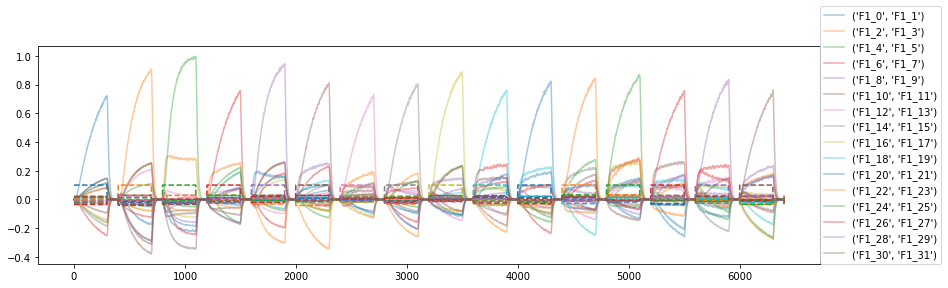

In [624]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

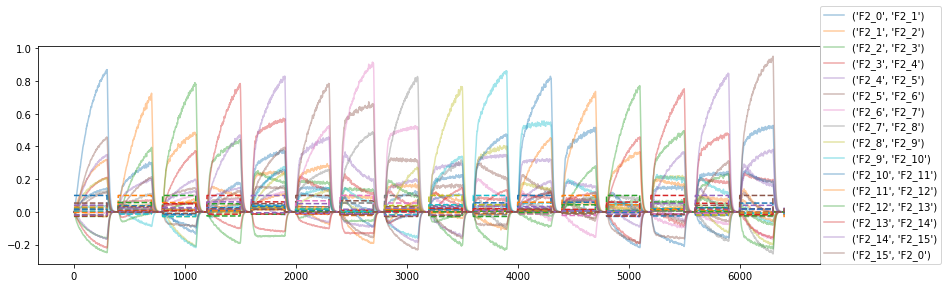

In [625]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [626]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 1000)

# Test

In [627]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)
    #nengo.Connection(ens, output)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

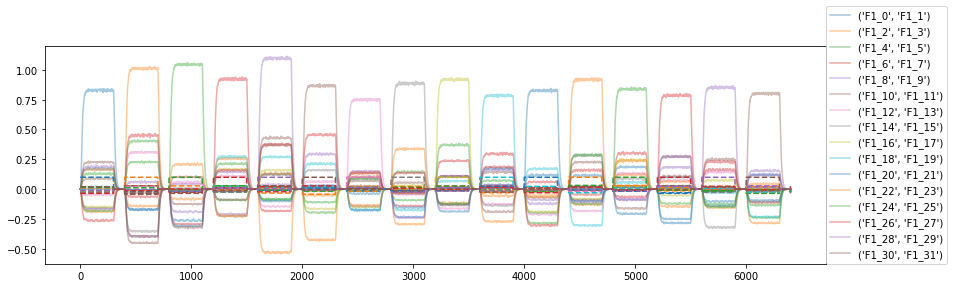

In [628]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

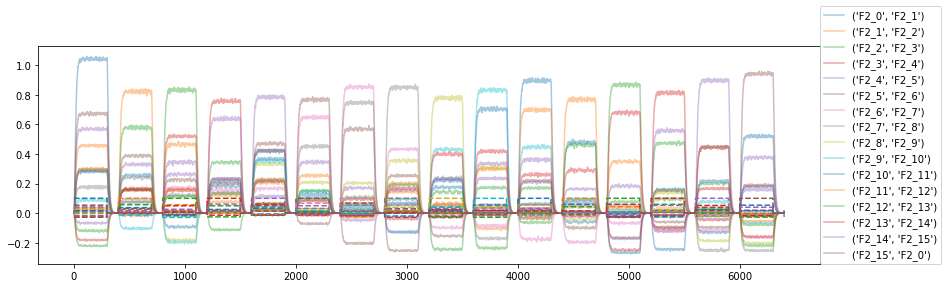

In [629]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

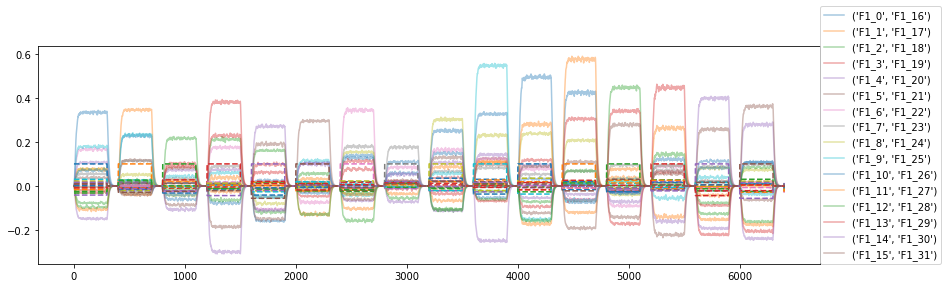

In [630]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [631]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [632]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [633]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [634]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[245.70963754 300.03492153 310.33321684 274.1698911  326.10527947
 257.28871529 222.80837486 262.59753999 272.91505667 232.67661074
 245.02163105 272.05138852 248.4398081  233.65771527 253.04361067
 238.22745927]
262.192553556286


In [635]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [636]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[309.84542042 244.06133039 246.97082746 224.79936534 232.82334696
 227.53045751 253.23857226 252.16110343 230.46994369 247.23615604
 265.44470185 227.7602062  257.13719111 241.50061767 266.54756778
 280.52888037]
250.50348052993957


## Compare reaction times

In [637]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [638]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [639]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 248.85387813540552
fan2 237.780659471553
foil1 104.20443956906925
foil2 158.46569008237282


In [640]:
conf_df = pd.DataFrame(confs)

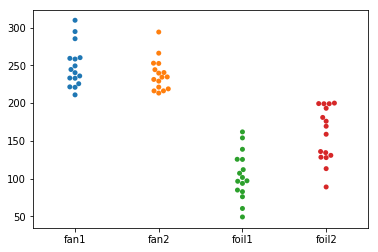

In [641]:
sns.swarmplot(data=conf_df)

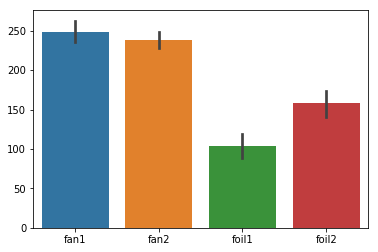

In [642]:
sns.barplot(data=conf_df)